In [1]:
script = False

import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
plt.style.use('dark_background')
import random
import copy

if(script): 
    from tqdm import tqdm
else:
    from tqdm.notebook import tqdm
    import ipython_bell

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 6.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 45 # 

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 10}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


In [3]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [4]:
# Function to pick a position on a caustic
def pick_center(ra_caustic_list, dec_caustic_list):
    l = random.randint(0, len(ra_caustic_list)-1)
    noise_ra, noise_dec = random.uniform(-0.3, 0.3), random.uniform(-0.3, 0.3)
    return(ra_caustic_list[l] + noise_ra, dec_caustic_list[l] + noise_dec)

In [5]:
#Makes 3 plots per image: source simulation, lens cutout, complete simulation
def make_graphs(name, sim_i, sim_r, sim_g, cutout_i, cutout_r, cutout_g):
    loc = plticker.MultipleLocator(base=3.75)
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), ncols=3)

    rgb = make_lupton_rgb(sim_i, sim_r, sim_g, Q=11., stretch=40.)
    ax1.set_title('Source(s)')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    original = ax1.imshow(rgb, aspect='equal')

    rgb = make_lupton_rgb(cutout_i, cutout_r, cutout_g, Q=11., stretch=40.)
    ax2.set_title('Lens')
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    cutout = ax2.imshow(rgb, aspect='equal')
            
    rgb = make_lupton_rgb(sim_i+cutout_i, sim_r+cutout_r, sim_g+cutout_g, Q=11., stretch=40.)
    ax3.set_title('Complete Simulation')
    ax3.xaxis.set_ticklabels([])
    ax3.yaxis.set_ticklabels([])
    projection = ax3.imshow(rgb, aspect='equal')
   
    sub_path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
    #plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()

In [6]:
#Writes 3 files for each simulation (one for each band). Folder is the ID, name n_g.fits
def write_files(ID, image_g, image_r, image_i, parameters):
    path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim/'
    folder = str(ID)
    if not os.path.exists(path + folder):
        os.makedirs(path + folder)
        n = 0
    else:
        n = len(os.listdir(path + folder))/3 #/3
    
    parameters['ID'] = ['POS_' + str(ID) + '_' + str(n)]
    names = ('zl/z1', 'm', 'iso', 'E', 'Magni 1', 'ID')
    
    parameters = Table(data=parameters, dtype=('f8', 'f8', 'f8', 'f8', 'f8', 'S'))
        
    primary = fits.PrimaryHDU(image_g)
    table = fits.BinTableHDU(data = parameters)
    hdul = fits.HDUList([primary, table])
    hdul.writeto(path + folder + '/' + str(int(n+1)) + '_g.fits')
    
    primary = fits.PrimaryHDU(image_r)
    hdul = fits.HDUList([primary])
    hdul.writeto(path + folder + '/' + str(int(n+1)) + '_r.fits')
    
    primary = fits.PrimaryHDU(image_i)
    hdul = fits.HDUList([primary])
    hdul.writeto(path + folder + '/' + str(int(n+1)) + '_i.fits')
    

In [7]:
#Calculating ~total flux
def calculate_flux(object, band):
    flux = np.sum(object[band])
    return(flux)

#Calculating AB magnitude
def calculate_magnitude(object, band):
    f = calculate_flux(object, band)
    m = -2.5*np.log10(f*10**(-12))
    return(m)

def calculate_magnification(delta_m):
    M = 100**(delta_m/5)
    return(M)

def isolation(image_source, image_lens, cumulative=0.9):
    """Compute a statistic to measure degree of source image isolation.
   
    Use the simulated image of the lensed source to define an effective weight
    map. Use the weight map to compute the weighted average flux within pixels 
    from the lensed source images and from the foreground lens. Return the 
    effective fraction of the total flux within this weighted aperture that is
    attributed to the source.

    isolation = <source_flux> / (<source_flux> + <lens_flux>)
 
    A weighted aperture is obtained by converting the simulated source image 
    into a PDF, removing the set of faint pixels that contain (1 - cumulative)
    of the total flux, and normalizing the weighted aperture such that integral 
    over all pixels in equal to one.

    Parameters
    ----------
    image_source : `numpy.ndarray` [`float`]
        Image of simulated lensed source; shape (n, n)
    image_lens : `np.ndarray` [`float`]
        Image of lens and other foreground objects; shape (n, n)
    cumulative : `float`
        Fraction of lens total flux to use when defining an aperture. 
        Default = 0.9.
    
    Returns
    -------
    isolation : `float`
        Mean flux fraction attributed to the source images within the weighted
        apertue.
    """
    
    weight = image_source  / np.sum(image_source)
    weight_sorted = np.sort(weight.flatten())
    threshold = weight_sorted[np.cumsum(weight_sorted) > (1. - cumulative)][0]
    aperture = weight > threshold

    weight_aperture = weight * aperture / np.sum(weight * aperture)

    mean_lens = np.sum(weight_aperture * image_lens) 
    mean_sources = np.sum(weight_aperture * image_source)
    isolation = mean_sources / (mean_sources + mean_lens)
    return isolation

# For source distributions: from redshift get magnitude, sersic radius & ellipticity
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/'
filename = 'source_distributions.csv'
data_dist = pd.read_csv(path + filename)
data_dist = data_dist[data_dist['MAG_PSF_G'] < 30.] [data_dist['MAG_PSF_R'] < 30.] [data_dist['MAG_PSF_I'] < 30.]
data_dist = data_dist[data_dist['SOF_CM_G_1'] > -100.][data_dist['SOF_CM_G_2'] > -100.]
data_dist = data_dist[data_dist['DNF_ZMEAN_SOF'] > 0.01][data_dist['DNF_ZMEAN_SOF'] < 2.9]
data_dist = data_dist.sort_values('DNF_ZMEAN_SOF').reset_index()

dz, dm = 0.1, 0.1 # Range of redshift and magnitude for filtering

#returns magnitude in g, r, i bands and r sersic
def distribution(z, mmax = 24.5, data=data_dist):
    new_data = data[data['DNF_ZMEAN_SOF'] > z - dz] [data['DNF_ZMEAN_SOF'] < z + dz] 
    m = new_data.sample()['MAG_PSF_G'].values[0]
    while(m > mmax):
        m = new_data.sample()['MAG_PSF_G'].values[0]
    new_data = new_data[new_data['MAG_PSF_G'] > m - dm] [new_data['MAG_PSF_G'] < m + dm]
    random_object = new_data.sample()
    mg, mr, mi = random_object['MAG_PSF_G'].values[0], random_object['MAG_PSF_R'].values[0], random_object['MAG_PSF_I'].values[0]
    rg, rr, ri = random_object['FLUX_RADIUS_G'].values[0], random_object['FLUX_RADIUS_R'].values[0], random_object['FLUX_RADIUS_I'].values[0]
    e1, e2 = random_object['SOF_CM_G_1'].values[0], random_object['SOF_CM_G_2'].values[0]
    magnitude = {'mg': mg, 'mr': mr, 'mi': mi}
    radius = {'rg': rg*DES_camera['pixel_scale'], 'rr': rr*DES_camera['pixel_scale'], 'ri': ri*DES_camera['pixel_scale']}
    ellipticity = {'e1': e1, 'e2': e2}
    return(magnitude, radius, ellipticity)

#z = 1.7 Max


In [8]:
def simulation(model, coadd_id, redshifts, lens, cuts, double):
   
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [redshifts['lens']],  # list of redshift of the deflections
                          # list of extended source models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE'],  
                          # list of redshfits of the sources in same order as source_light_model_list
                          'source_redshift_list': [redshifts['source1']],  
                          'cosmo': cosmo,  # astropy.cosmology instance
                          # redshift of the default source (if not further specified by 'source_redshift_list')
                          'z_source': redshifts['source1']} 
                           #and also serves as the redshift of lensed point sources}

    if(double == True):
        kwargs_model_physical['source_light_model_list'].append('SERSIC')
        kwargs_model_physical['source_redshift_list'].append(redshifts['source2'])
        kwargs_model_physical['z_source'] = redshifts['source2']
        
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    #lens mass model
    kwargs_mass = [{'sigma_v': lens['sigma'], 'center_x': 0, 'center_y': 0, 
                    'e1': lens['e1'], 'e2': lens['e2']}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    
    #caustics and critical curves
    ra_crit_list, dec_crit_list, ra_caustic_list, dec_caustic_list = model['model_ext'].critical_curve_caustics(kwargs_lens, 
                                                                compute_window=15, grid_scale=0.01, center_x=0, center_y=0)
    if(len(ra_caustic_list)==0): return('No caustics')
    ra_caustic_list, dec_caustic_list = ra_caustic_list[0], dec_caustic_list[0]
    
    #cut on the Einstein radius of the lens
    if(kwargs_lens[0]['theta_E'] < cuts['E_min'] or kwargs_lens[0]['theta_E'] > cuts['E_max']):
        return ('No cut E')
    
    #First source light distributions & colors of the other bands for each source
    mag1, rad1, ellip1 = distribution(redshifts['source1'])
    n1 = random.uniform(0.3, 4.)
    
    #Pick center of first source on the caustic
    c1x, c1y = pick_center(ra_caustic_list, dec_caustic_list)
    #theta_ra, theta_dec = model['solver'].image_position_from_source(c1x, c1y, kwargs_lens)
    #magni1 = model['lensModel'].magnification(theta_ra, theta_dec, kwargs_lens)
    
    #if(len(magni1)==0): return('No magni')
    
    #First source light:
    kwargs_source_mag_g_1 = [{'magnitude': mag1['mg'], 'R_sersic': rad1['rg'], 'n_sersic': n1,
                              'e1': ellip1['e1'], 'e2': ellip1['e2'], 'center_x': c1x, 'center_y': c1y}]
    #Adding color distribution to the bands (first source):
    kwargs_source_mag_r_1 = copy.deepcopy(kwargs_source_mag_g_1)
    kwargs_source_mag_r_1[0]['magnitude'], kwargs_source_mag_r_1[0]['R_sersic'] = mag1['mr'], rad1['rr']
    kwargs_source_mag_i_1 = copy.deepcopy(kwargs_source_mag_g_1)
    kwargs_source_mag_i_1[0]['magnitude'], kwargs_source_mag_i_1[0]['R_sersic'] = mag1['mi'], rad1['ri']
    #Same for second source
    if(double == True):
        mag2, rad2, ellip2 = distribution(redshifts['source2'])
        n2 = random.uniform(0.3, 4.)
        c2x, c2y = pick_center(ra_caustic_list, dec_caustic_list)
        theta_ra, theta_dec = model['solver'].image_position_from_source(c2x, c2y, kwargs_lens)
        magni2 = model['lensModel'].magnification(theta_ra, theta_dec, kwargs_lens)
        kwargs_source_mag_g_2 = [{'magnitude': mag2['mg'], 'R_sersic': rad2['rg'], 'n_sersic': n2, 
                              'center_x': c2x, 'center_y': c2y}]
        kwargs_source_mag_r_2 = copy.deepcopy(kwargs_source_mag_g_2)
        kwargs_source_mag_r_2[0]['magnitude'], kwargs_source_mag_r_2[0]['R_sersic'] = mag2['mr'], rad2['rr']
        kwargs_source_mag_i_2 = copy.deepcopy(kwargs_source_mag_g_2)
        kwargs_source_mag_i_2[0]['magnitude'], kwargs_source_mag_i_2[0]['R_sersic'] = mag2['mi'], rad2['ri']
        
    kwargs_source_mag_g = kwargs_source_mag_g_1 + kwargs_source_mag_g_2 if(double) else kwargs_source_mag_g_1 
    kwargs_source_mag_r = kwargs_source_mag_r_1 + kwargs_source_mag_r_2 if(double) else kwargs_source_mag_r_1 
    kwargs_source_mag_i = kwargs_source_mag_i_1 + kwargs_source_mag_i_2 if(double) else kwargs_source_mag_i_1 
    
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_r, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_i, kwargs_ps_mag=None)
    
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i)
    
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)
    image_i += sim_i.noise_for_model(model=image_i)
    
    image_g = image_g[::-1]
    image_r = image_r[::-1]
    image_i = image_i[::-1]
    
    if(np.isnan(np.sum(image_g))): 
        return('IS NAN!!!!!')
    
    object_sim = np.array([image_g, image_r, image_i])
    if(double == False):
        m = calculate_magnitude(object_sim, 0) #band 0 = g band
        if(m > cuts['mmax'] or m < cuts['mmin']):
            return ('No cut mag')
    else:
        m = mag1['mg']
    
    directory_cutouts = 'Data/new_lens_cutouts/' + str(coadd_id)
    with fits.open(directory_cutouts + '_g.fits') as hdul: lens_g = hdul[0].data
    with fits.open(directory_cutouts + '_i.fits') as hdul: lens_i = hdul[0].data
    with fits.open(directory_cutouts + '_r.fits') as hdul: lens_r = hdul[0].data
    
    iso_g, iso_i, iso_r = isolation(image_g,lens_g), isolation(image_i, lens_i), isolation(image_r, lens_r)
    iso_ave = np.mean([iso_g, iso_i, iso_r])
    Mag = calculate_magnification(mag1['mg'] - m)
    
    if(iso_ave < cuts['iso_min'] or iso_ave > cuts['iso_max']): return('No cut isolation')
    
    if(Mag < cuts['magni_min'] or Mag > cuts['magni_max']): return('No cut magnification')
    
    parameters = {'zl/z1': [redshifts['lens']/redshifts['source1']], 'm': [m], 'iso': [iso_ave], 'E': [kwargs_lens[0]['theta_E']], 'Magni 1': [Mag]}
    
    write_files(coadd_id, image_g, image_r, image_i, parameters)  
    make_graphs('example_simulations', image_i, image_r, image_g, lens_i, lens_r, lens_g)
    
    return ('ok')
    

In [9]:
complete_data = pd.read_csv('Data/all_data_sim.csv')
print(len(complete_data))

19682


In [10]:
def simulations_from_data(num, double):
    num_sim = 0
    #data = complete_data.sample(n = 60000, replace = True).reset_index() #(frac=1)
    
    lens_model_list = ['SIE']
    lensModel = LensModel(lens_model_list=lens_model_list)
    lensModelExt = LensModelExtensions(lensModel)
    solver = LensEquationSolver(lensModel)
    
    model = {'lensModel': lensModel, 'model_ext': lensModelExt, 'solver': solver}
    
    #for index, row in tqdm(data.iterrows()):
    #    if index == num_max:
    #        break
    while (num_sim < num):
        row = complete_data.sample(n = 1).reset_index().iloc[0]
        DES_g_band_obs['seeing'] = row['FWHM_WMEAN_G'] 
        DES_r_band_obs['seeing'] = row['FWHM_WMEAN_R']
        DES_i_band_obs['seeing'] = row['FWHM_WMEAN_I']
        
        coadd_id = int(row['Y6_COADD_OBJECT_ID'])
        directory_cutouts = 'Data/new_lens_cutouts/' + str(coadd_id) + '_g.fits'
        if(os.path.exists(directory_cutouts) == False): continue
        z_lens = row['Z']
        z1_max = random.uniform(0.4, 0.8)
        z_source1 = random.uniform(z_lens, z_lens + z1_max) # 1.2
        z_source2 = random.uniform(z_source1, 1.7) # 0.35
        redshifts = {'lens': z_lens, 'source1': z_source1, 'source2': z_source2}
        angle, ratio = param.ellipticity2phi_q(row['SOF_BDF_G_1'], row['SOF_BDF_G_2'])
        angle += 0.698132*random.uniform(-1, 1) #noise between -40 and 40 degrees
        ratio = random.uniform(0.001, 1) #distribution for the axis ratio
        e1, e2 = param.phi_q2_ellipticity(angle, ratio)
        lens = {'sigma': row['VEL_DISP'] + 150, 'e1': e1, 'e2': e2}
        
        status = simulation(model, coadd_id, redshifts, lens, cuts, double)
        
        """
        while(status == 'No cut mmag' or status == 'No cut isolation'):
            z1_max = random.uniform(0.4, 0.8)
            z_source1 = random.uniform(z_lens, z_lens + z1_max)
            redshifts = {'lens': z_lens, 'source1': z_source1, 'source2': z_source2}
            status = simulation(model, coadd_id, redshifts, lens, cuts, double)
            #print(status)
        """
        
        if(status == 'ok'):
            num_sim += 1
    print(num_sim)
            

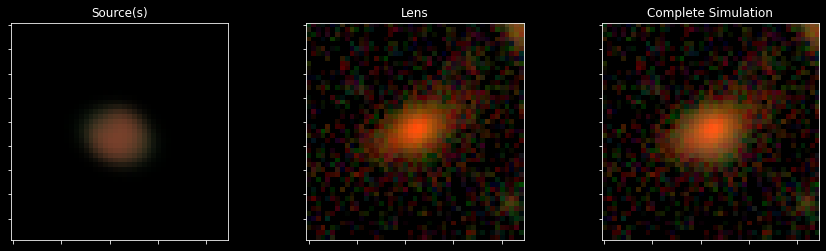

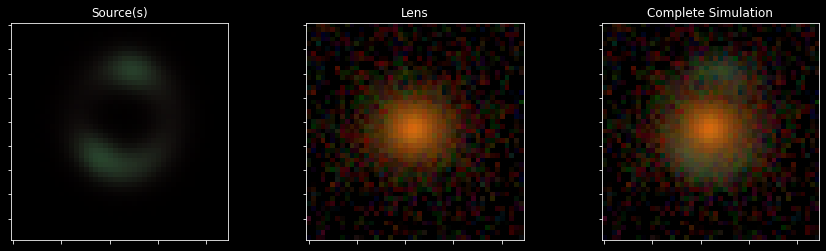

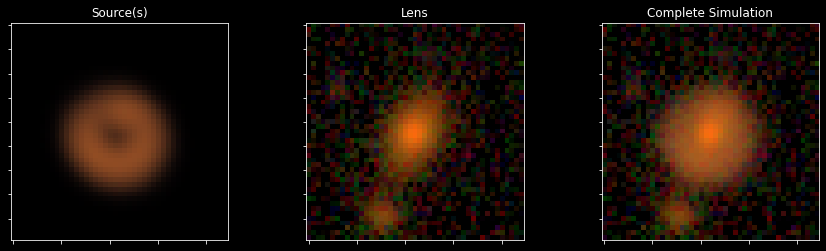

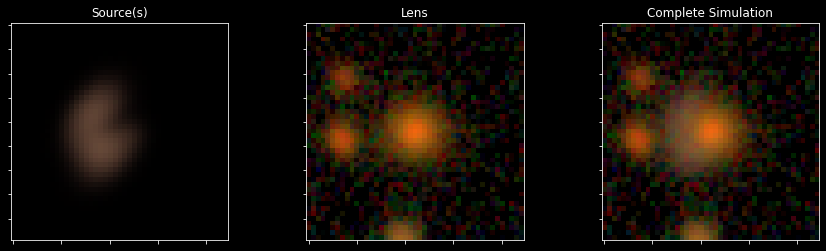

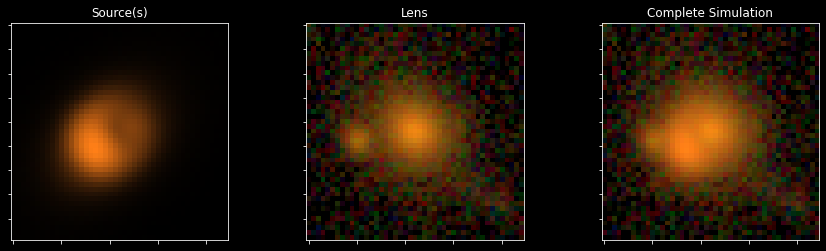

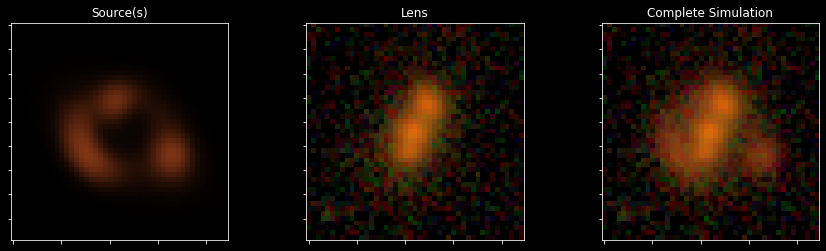

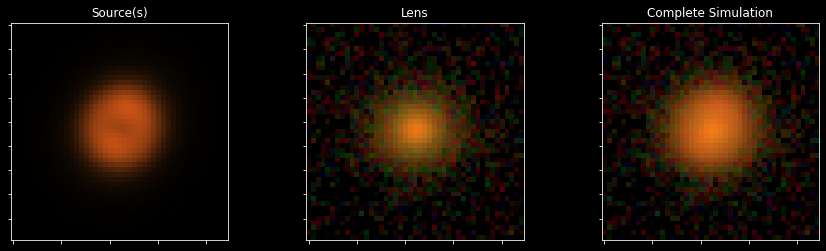

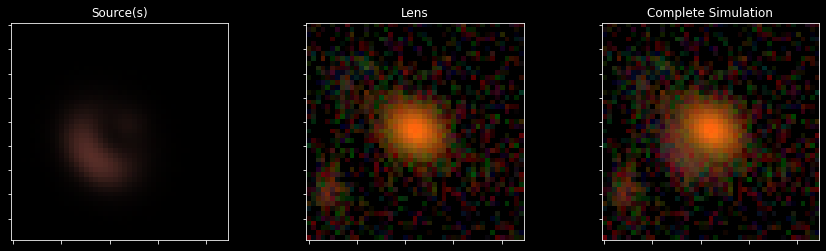

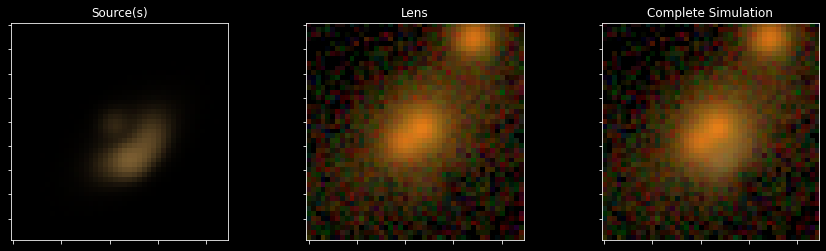

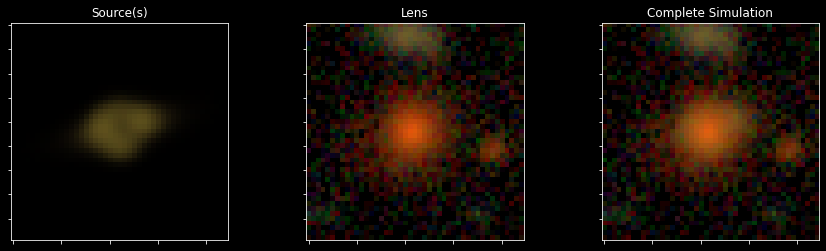

10


In [11]:
seed = 0
seed_everything(seed)
complete_data = pd.read_csv('Data/all_data_sim.csv')

mmin, mmax, E_min, E_max, iso_min, iso_max, magni_min, magni_max = 15, 23.5, 0.4, 4., 0.4, 1000, 2.5, 1000
cuts = {'E_max': E_max, 'E_min': E_min, 'mmax': mmax, 'mmin': mmin, 'iso_min': iso_min, 'iso_max': iso_max,
               'magni_min': magni_min, 'magni_max': magni_max}
simulations_from_data(num = 10, double=False)

In [12]:
#bell -n say

In [13]:
print('\a')
print('\a')
print('\a')
print('\a')







In [14]:
#! convert -delay 50 -loop 0 *.png Only_sources_data.gif
#! rm *.png